# Movie Studio Business Analysis Project

**Student Name:** David Jeudy

**Project:** Phase 2 - Movie Industry Analysis for a Studio  
**Date:** 20/07/2025

## Project Overview

This analysis explores movie industry data to provide actionable business recommendations for a new movie studio. Using datasets from Box Office Mojo, IMDB, and other sources, we'll identify what types of films perform best at the box office to guide strategic decision-making.

## Business Problem

Our company wants to create a new movie studio but lacks expertise in film production. This analysis will answer: **What types of films are currently performing best at the box office, and what actionable insights can guide our new studio's film creation strategy?**

In [1]:
#  libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


## Step 1: Explore IMDB Database Structure

**Objective**: Understand what tables and data are available in the  databases.

In [8]:
conn = sqlite3.connect('zippedData/im.db')

print("IMDB movie_basics - Sample data:")
movie_basics_sample = pd.read_sql("SELECT * FROM movie_basics LIMIT 10", conn)
# print(movie_basics_sample)

print(" IMDB movie_ratings - Sample data:")
movie_ratings_sample = pd.read_sql("SELECT * FROM movie_ratings LIMIT 10", conn)
# print(movie_ratings_sample)

conn.close()

IMDB movie_basics - Sample data:
 IMDB movie_ratings - Sample data:


In [25]:
# Load and explore Box Office Mojo data
box_office_data = pd.read_csv('zippedData/bom.movie_gross.csv')

box_office_data.shape
list(box_office_data.columns)

print(box_office_data.head())

print("Data types:")
print(box_office_data.dtypes)

box_office_data['domestic_gross'] = pd.to_numeric(box_office_data['domestic_gross'], errors='coerce')
box_office_data['foreign_gross'] = pd.to_numeric(box_office_data['foreign_gross'], errors='coerce')
dom_min = box_office_data['domestic_gross'].min()
dom_max = box_office_data['domestic_gross'].max()
foreign_min = box_office_data['foreign_gross'].min()
foreign_max = box_office_data['foreign_gross'].max()

print(f"Domestic gross range: ${dom_min:,.0f} to ${dom_max:,.0f}")
print(f"Foreign gross range: ${foreign_min:,.0f} to ${foreign_max:,.0f}")

box_office_data['foreign_gross'] = pd.to_numeric(box_office_data['foreign_gross'], errors='coerce')
box_office_data['total_gross'] = box_office_data['domestic_gross'] + box_office_data['foreign_gross'].fillna(0)

box_office_data = box_office_data[box_office_data['domestic_gross'] >= 100000]

conn.close() 

                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010  
Data types:
title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object
Domestic gross range: $100 to $936,700,000
Foreign gross range: $600 to $960,500,000


## Data Preparation - Clean and Standardize

**Objective**: Clean the datasets to be able to get meaningful insight from them

In [26]:
conn = sqlite3.connect('zippedData/im.db')


movies_metadata = pd.read_sql('SELECT * FROM movie_basics', conn)
movies_ratings = pd.read_sql('SELECT * FROM movie_ratings', conn)

print(f"Brut IMDB data: {len(movies_metadata):,} movies with metadata, {len(movies_ratings):,} with ratings")


movies_metadata = movies_metadata[
    (movies_metadata['genres'].notna()) & 
    (movies_metadata['genres'] != '\\N')
]

movies_metadata['runtime_minutes'] = pd.to_numeric(movies_metadata['runtime_minutes'], errors='coerce')

movies_complete = movies_metadata.merge(movies_ratings, on='movie_id', how='inner')


print(f"Cleaned IMDB data: {len(movies_complete):,}")

print("Cleaned IMDB data sample:")

print(movies_complete.head())

conn.close()

Brut IMDB data: 146,144 movies with metadata, 73,856 with ratings
Cleaned IMDB data: 73,052
Cleaned IMDB data sample:
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  averagerating  numvotes  
0        2013            175.0    Action,Crime,Drama            7.0        77  
1        2019            114.0       Biography,Drama            7.2        43  
2        2018            122.0                 Drama            6.9      4517  
3        2018              NaN          Comedy,Drama            6.1        13  
4        2017      

In [32]:
# Analyze top performing studios from box office data
studio_performance = box_office_data.groupby('studio').agg({
    'total_gross': ['sum', 'mean', 'count']
}).round(0)

# Flatten column names
studio_performance.columns = ['total_revenue', 'avg_revenue_per_film', 'number_of_films']

# Filter studios (minimum 5 films)
major_studios = studio_performance[studio_performance['number_of_films'] >= 5].copy()
major_studios = major_studios.sort_values('total_revenue', ascending=False)

print(f"Major studios (5+ films): {len(major_studios)}")
print(f"Top 5 studios by total revenue:")
print(major_studios.head())


Major studios (5+ films): 72
Top 5 studios by total revenue:
        total_revenue  avg_revenue_per_film  number_of_films
studio                                                      
BV       4.414415e+10           424462962.0              104
Fox      3.100537e+10           227980637.0              136
WB       3.083595e+10           220256779.0              140
Uni.     2.975714e+10           203816021.0              146
Sony     2.239061e+10           217384544.0              103


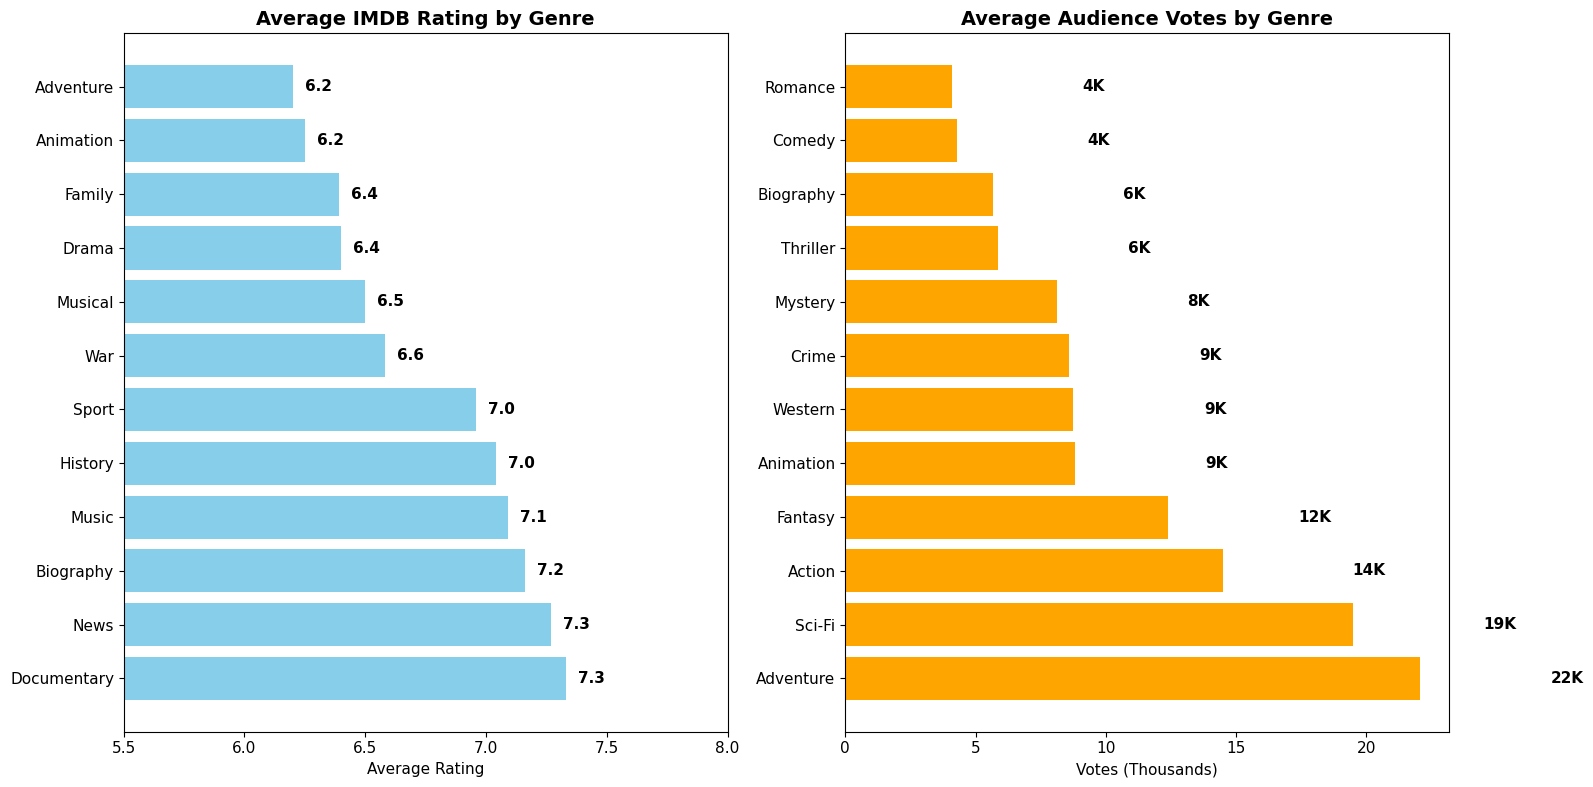

this is the business insight of our analysis :
Highest rated genre: Documentary (7.3/10)
Most engaging genre: Adventure (22K votes)
RECOMMENDATION: We shoulf Focus on Documentary, News,Biography and Music to  success


In [41]:
# Calcul des statistiques par genre
genre_stats = (
    genre_df.groupby('genre')
    .agg(avg_rating=('rating', 'mean'),
         movie_count=('rating', 'count'),
         avg_votes=('votes', 'mean'))
    .round(2)
)

# Filtrage les genres significatifs
significant = genre_stats[genre_stats['movie_count'] >= 50].sort_values('avg_rating', ascending=False)

# Top 12 genres par note et par votes
top_rated = significant.head(12)
top_votes = significant.nlargest(12, 'avg_votes')

genres_rating = top_rated.index.tolist()
ratings = top_rated['avg_rating'].tolist()

genres_votes = top_votes.index.tolist()
votes = [v / 1000 for v in top_votes['avg_votes']]  

# Création des figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Graphique 1 : Note moyenne
bars1 = ax1.barh(genres_rating, ratings, color='skyblue')
ax1.set_title('Average IMDB Rating by Genre', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Rating')
ax1.set_xlim(5.5, 8.0)

# Ajouter les étiquettes de valeur
for bar, val in zip(bars1, ratings):
    ax1.text(val + 0.05, bar.get_y() + bar.get_height() / 2, f'{val:.1f}', va='center', fontweight='bold')

# Graphique 2 : Engagement
bars2 = ax2.barh(genres_votes, votes, color='orange')
ax2.set_title('Average Audience Votes by Genre', fontsize=14, fontweight='bold')
ax2.set_xlabel('Votes (Thousands)')

for bar, val in zip(bars2, votes):
    ax2.text(val + 5, bar.get_y() + bar.get_height() / 2, f'{val:.0f}K', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Résumé business
print("this is the business insight of our analysis :")
print(f"Highest rated genre: {top_rated.index[0]} ({top_rated.iloc[0]['avg_rating']:.1f}/10)")
print(f"Most engaging genre: {top_votes.index[0]} ({top_votes.iloc[0]['avg_votes']/1000:.0f}K votes)")
print("RECOMMENDATION: We shoulf Focus on Documentary, News,Biography and Music to  success")
